>[Поиск по изображениям](#scrollTo=uAM1FqkBOGI7)

>>[Описание проекта](#scrollTo=1-qZW5gX92qO)

>>[Исследовательский анализ данных](#scrollTo=xn9QeLJ2OFvo)

>>>[Вывод](#scrollTo=GaW3CbthRaXp)

>>[Проверка данных](#scrollTo=Su4PPAbxN8fQ)

>>>[Юридические ограничения](#scrollTo=FC3nhgPZZK5E)

>>>>[Вывод по результатам обработки](#scrollTo=msrdYrBJAP9R)

>>>[Векторизация изображений](#scrollTo=-dZ4YsR9Y5pE)

>>>[Векторизация текста](#scrollTo=IPiHgTESHasw)

>>>[Объединение векторов](#scrollTo=3MedsOtXGyFj)

>>>[Выводы](#scrollTo=D4-_2UXd-ZmR)

>>[Обучение модели предсказания соответствия](#scrollTo=E3n5EPEDGmxJ)

>>>[LinearRegression](#scrollTo=MJMD9R2rHGKJ)

>>>[DecisionTree](#scrollTo=U6bJZmr0HM4a)

>>>[RandomForest](#scrollTo=fRgKJpxQe_nw)

>>>[Нейронная сеть](#scrollTo=Wi9LLHjNKmEi)

>>>[Выводы](#scrollTo=JUAYiHGB8JQ-)

>[Тестирование модели](#scrollTo=l8bI9Fnjb432)

>>>[Сравнение моделей](#scrollTo=1wBuXDxj80Gr)

>>>>[Вывод](#scrollTo=--eykt0_LC8t)

>>>[Тестирование модели на изображениях](#scrollTo=PPY1wDXd88iy)

>>[Общий вывод](#scrollTo=b8lmV8Jm_CAg)



# Поиск по изображениям

## Описание проекта

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Исследовательский анализ данных

In [1]:
# Загружаем бибилотеки.
import pandas as pd
import math
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords 
import spacy
import numpy as np
import re
from sklearn.model_selection import GroupShuffleSplit
import torchvision.models as models
tqdm.pandas()
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from math import sqrt, ceil

https://drive.google.com/file/d/1s27p9B3gYrEg1cPUChcR82w5ajumtdnV/view?usp=share_link

In [4]:
# Загружаем датасет с запросами картинками.
train = pd.read_csv('/content/to_upload/train_dataset.csv')

In [5]:
train.sample(10) # Проверяем загрузку данных.

image                     query_id  \
2928   270724499_107481c88f.jpg   566397227_a469e9e415.jpg#2   
3782   751109943_2a7f8e117f.jpg  2436081047_bca044c1d3.jpg#2   
3451  3024172109_a10198e1dd.jpg  3571147934_d1c8af1d6e.jpg#2   
220    191003285_edd8d0cf58.jpg   191003285_edd8d0cf58.jpg#2   
4975  2479652566_8f9fac8af5.jpg   488356951_b3b77ad832.jpg#2   
1900  2844018783_524b08e5aa.jpg   435827376_4384c3005a.jpg#2   
2471  3514179514_cbc3371b92.jpg   132489044_3be606baf7.jpg#2   
5637  3422458549_f3f3878dbf.jpg  3422458549_f3f3878dbf.jpg#2   
1393   244571201_0339d8e8d1.jpg  3564543247_05cdbc31cf.jpg#2   
5022  3280052365_c4644bf0a5.jpg   261490838_2f3ac98b12.jpg#2   

                                             query_text  
2928  A small boy with braids runs through a field o...  
3782  A little girl wearing a pink shirt jumps off a...  
3451  Kids are waiting at the bottom of a staircase ...  
220   A man and young girl eat a meal on a city stre...  
4975  Talk between man in Hawaiian shirt , older man...  
1900  A man and a woman walking down a street , carr...  
2471    An asian man in a suit on the subway , asleep .  
5637  A tennis player in orange is striking the ball...  
1393                     Two guys jumping into a pool .  
5022  A dog chasing a deer in a field of yellow flow...

In [6]:
# Загружаем датасет с оценками экспертов.
expert = pd.read_csv('/content/to_upload/ExpertAnnotations.tsv', sep='\t', header=None)

In [7]:
expert.sample(10) # Проверяем загрузку данных.

0                            1  2  3  4
81    1174629344_a2e1a2bdbf.jpg  1329832826_432538d331.jpg#2  2  2  2
1497  2473738924_eca928d12f.jpg  3545586120_283d728a97.jpg#2  1  2  3
4963   370713359_7560808550.jpg  2105756457_a100d8434e.jpg#2  1  1  1
5622    57422853_b5f6366081.jpg  3437147889_4cf26dd525.jpg#2  1  1  1
287   1389264266_8170bc1c54.jpg  2666179615_f05a9d8331.jpg#2  1  2  3
5563   542179694_e170e9e465.jpg  3100251515_c68027cc22.jpg#2  1  1  1
2823  3044500219_778f9f2b71.jpg  3143982558_9e2d44c155.jpg#2  1  1  1
2026  2682382530_f9f8fd1e89.jpg  3214885227_2be09e7cfb.jpg#2  1  2  2
1652  2526041608_a9775ab8d7.jpg  2729655904_1dd01922fb.jpg#2  1  1  2
5013  3729525173_7f984ed776.jpg   421730441_6b2267fd31.jpg#2  1  2  3

In [8]:
# Загружаем датасет данными краудсорсинга.
crowd = pd.read_csv('/content/to_upload/CrowdAnnotations.tsv', sep='\t', header=None)

In [9]:
crowd.sample(10) # Проверяем загрузку данных.

0                            1    2  3  4
46356   670609997_5c7fdb3f0b.jpg  2860872588_f2c7b30e1a.jpg#2  0.0  0  3
35209  3485425825_c2f3446e73.jpg   138718600_f430ebca17.jpg#2  0.0  0  3
2609   1427391496_ea512cbe7f.jpg  2521770311_3086ca90de.jpg#2  0.0  0  3
12819  2496370758_a3fbc49837.jpg   308487515_7852928f90.jpg#2  0.0  0  3
41653  3745451546_fc8ec70cbd.jpg  3385246141_a263d1053e.jpg#2  0.0  0  3
21607  2950905787_f2017d3e49.jpg  2473791980_805c819bd4.jpg#2  0.0  0  3
13683  2534502836_7a75305655.jpg  3044536048_e615466e7f.jpg#2  0.0  0  3
12505  2480850054_de3433b54a.jpg  3565598162_56044bc2f7.jpg#2  0.0  0  3
3132   1490670858_e122df2560.jpg  3360930596_1e75164ce6.jpg#2  0.0  0  3
19911  2891617125_f939f604c7.jpg  3375070563_3c290a7991.jpg#2  0.0  0  3

In [10]:
expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [11]:
crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [13]:
# Переименуем колонки.
expert.columns = ['image', 'query_id', 'ex_1', 'ex_2', 'ex_3']

In [14]:
# Переименуем колонки.
crowd.columns = ['image', 'query_id', 'fraction', 'consonants', 'dissenters']

In [15]:
# Присоединим оценки экспертов.
train = train.merge(expert, how='left', on=['image', 'query_id'])

In [16]:
# Проверим результат.
train.sample(10)

image                     query_id  \
4784  3317073508_7e13565c1b.jpg   241346508_0b3907a95b.jpg#2   
5203  2594902417_f65d8866a8.jpg  3537400880_8f410d747d.jpg#2   
3334  3506468593_7e41a6d9f1.jpg   448252603_7d928c900e.jpg#2   
930   3613424631_3ae537624f.jpg  2902269566_419d9f1d8e.jpg#2   
1530  2501595799_6316001e89.jpg  2265096094_8cc34d669c.jpg#2   
1288  3427233064_6af01bfc5c.jpg  3203908917_53e53c03d1.jpg#2   
5473  3596131692_91b8a05606.jpg  3596131692_91b8a05606.jpg#2   
5317  2991994415_504d1c0a03.jpg  3123463486_f5b36a3624.jpg#2   
3053  1764955991_5e53a28c87.jpg  2831217847_555b2f95ca.jpg#2   
101    512101751_05a6d93e19.jpg  2398605966_1d0c9e6a20.jpg#2   

                                             query_text  ex_1  ex_2  ex_3  
4784  The football players in red are attempting a p...     1     2     3  
5203  Girl in black and white top and black leggings...     1     1     1  
3334  A man points his finger to the path ahead as h...     1     1     1  
930                                  Man on a dirt bike     2     2     3  
1530  A mule is carring a man in a cart next to some...     1     1     1  
1288                         Men burn an Israeli flag .     1     1     1  
5473  Three children in neon colors play soccer whil...     4     4     4  
5317                     A little dog running on sand .     1     1     1  
3053  A blue SUV drives in a stream surrounded by wo...     1     2     2  
101   Two long-haired puppy dogs have a romp in the ...     1     2     2

In [17]:
# Присоединим данные краудсорсинга.
train = train.merge(crowd,  how='left', on=['image', 'query_id'])

In [18]:
train.info() # Проверим общий результат.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   ex_1        5822 non-null   int64  
 4   ex_2        5822 non-null   int64  
 5   ex_3        5822 non-null   int64  
 6   fraction    2329 non-null   float64
 7   consonants  2329 non-null   float64
 8   dissenters  2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 454.8+ KB


In [19]:
# Функция expert_score предназначена для выдачи обобщенной оценки экспертов, на вход принемет строку датасета.

def expert_score(row):
  if (row['ex_1'] == row['ex_2']) or (row['ex_1'] == row['ex_3']):
    return row['ex_1']
  elif (row['ex_2'] == row['ex_3']):
    return row['ex_2']
  else:
    return 0

In [20]:
# Считаем обобщеную оценку экспертов.
train['expert_score'] = train.apply(expert_score, axis=1)

In [21]:
train.sample(10) # Проверим результат.

image                     query_id  \
2469  3214573346_d3a57f0328.jpg   132489044_3be606baf7.jpg#2   
4939  3061481868_d1e00b1f2e.jpg  3354883962_170d19bfe4.jpg#2   
98    2525270674_4ab536e7ec.jpg  2398605966_1d0c9e6a20.jpg#2   
5059  3115174046_9e96b9ce47.jpg  2431470169_0eeba7d602.jpg#2   
4025  3437147889_4cf26dd525.jpg  2739331794_4ae78f69a0.jpg#2   
2222  3211556865_d1d9becf69.jpg  3442242092_e579538d82.jpg#2   
2786  3207358897_bfa61fa3c6.jpg   524105255_b346f288be.jpg#2   
3495  3154641421_d1b9b8c24c.jpg  3155451946_c0862c70cb.jpg#2   
4360  3473264983_67917a931f.jpg  2885387575_9127ea10f1.jpg#2   
5140   396360611_941e5849a3.jpg  3532205154_5674b628ea.jpg#2   

                                             query_text  ex_1  ex_2  ex_3  \
2469    An asian man in a suit on the subway , asleep .     1     1     1   
4939     A white dog runs past a fence on a snowy day .     1     1     1   
98    Two long-haired puppy dogs have a romp in the ...     1     2     2   
5059  Man reading a newspaper at an outdoors restaur...     1     2     2   
4025              A motorcyclist races around a track .     3     3     4   
2222  The Asian girl wearing a pink and black stripe...     1     1     1   
2786                A woman looking at view of a city .     1     1     2   
3495     Three basketball players leap to grab a ball .     2     3     3   
4360                     a dog playing with a blue ball     1     1     1   
5140  A man with a shocked expression on his face is...     1     1     2   

      fraction  consonants  dissenters  expert_score  
2469       NaN         NaN         NaN             1  
4939       NaN         NaN         NaN             1  
98         NaN         NaN         NaN             2  
5059  0.000000         0.0         3.0             2  
4025  0.333333         1.0         2.0             3  
2222  0.000000         0.0         3.0             1  
2786  0.000000         0.0         3.0             1  
3495  0.000000         0.0         3.0             3  
4360  0.000000         0.0         3.0             1  
5140       NaN         NaN         NaN             1

In [22]:
train[train['expert_score'] == 0]['image'].count() # Количество записей, где эксперты не определились.

126

In [23]:
train = train[train['expert_score'] != 0].copy() # Удалим записи, где эксперты не определились.

In [24]:
# Функция xpert_score_norm предназначена для первода оценок экспертов в диапазон от 0 до 1, на вход принемеn число.
def expert_score_norm(x):
  if x == 4:
    return 1
  elif x == 3:
    return 2 / 3
  elif x == 2:
    return 1 / 3
  else:
    return 0

In [25]:
# Проводим первод оценки экспертов. 
train['expert_score_norm'] = train['expert_score'].apply(expert_score_norm)

In [26]:
train.sample(10) # Проверим результат.

image                     query_id  \
2035  2926233397_71e617f3a3.jpg  2194286203_5dc620006a.jpg#2   
4973  3518126579_e70e0cbb2b.jpg  2306674172_dc07c7f847.jpg#2   
1200  3610683688_bbe6d725ed.jpg  3413571342_b9855795e2.jpg#2   
2391   534875358_6ea30d3091.jpg  2078311270_f01c9eaf4c.jpg#2   
2870  2073964624_52da3a0fc4.jpg  2600867924_cd502fc911.jpg#2   
796   2251747182_6b67a3ab8b.jpg  3218480482_66af7587c8.jpg#2   
4296  2225231022_1632d0a5aa.jpg  3162045919_c2decbb69b.jpg#2   
2912  3630641436_8f9ac5b9b2.jpg   327415627_6313d32a64.jpg#2   
5241  3045613316_4e88862836.jpg  2839038702_e168128665.jpg#2   
3969  2589241160_3832440850.jpg   247704641_d883902277.jpg#2   

                                             query_text  ex_1  ex_2  ex_3  \
2035                    boy and girl make a sand castle     1     1     1   
4973  A skateboarder jumps his board down a flight o...     3     3     4   
1200      A surfer rides a wave in a clear blue ocean .     1     2     2   
2391        Two women crossing the street on a cold day     1     2     2   
2870  Two dogs , one brown and white and one black a...     1     1     1   
796   A Miami basketball player dribbles by an Arizo...     2     2     2   
4296                         A man in a wetsuit surfs .     1     1     1   
2912                     Two dogs run through a field .     2     2     3   
5241  A dog stands at the top of a mountain and look...     2     2     2   
3969        A dog walks on a log across a small river .     2     2     2   

      fraction  consonants  dissenters  expert_score  expert_score_norm  
2035       NaN         NaN         NaN             1           0.000000  
4973       NaN         NaN         NaN             3           0.666667  
1200       NaN         NaN         NaN             2           0.333333  
2391       NaN         NaN         NaN             2           0.333333  
2870       NaN         NaN         NaN             1           0.000000  
796        0.0         0.0         3.0             2           0.333333  
4296       NaN         NaN         NaN             1           0.000000  
2912       0.0         0.0         3.0             2           0.333333  
5241       0.0         0.0         3.0             2           0.333333  
3969       0.0         0.0         3.0             2           0.333333

In [27]:
# Функция score расчитывает обобщеную оценку экспертов и краудсорсинга, на вход принемет строку датасета.
def score(row):
  if math.isnan(row['fraction']) :
    return row['expert_score_norm']
  else:
    return round(0.6 * row['expert_score_norm'] + 0.4 * row['fraction'], 3)

In [28]:
 # Рассчитываем обобщению оценку.
train['score'] = train.apply(score, axis=1)

In [29]:
train.sample(10) # Проверим результат.

image                     query_id  \
5094  3328646934_5cca4cebce.jpg  3399284917_721aefe2a7.jpg#2   
4785  3396157719_6807d52a81.jpg   241346508_0b3907a95b.jpg#2   
772   2443380641_7b38d18f5b.jpg  3028969146_26929ae0e8.jpg#2   
1730  2623930900_b9df917b82.jpg  3320356356_1497e53f80.jpg#2   
1999  1394368714_3bc7c19969.jpg  3597326009_3678a98a43.jpg#2   
2117  2708686056_1b8f356264.jpg   533979933_a95b03323b.jpg#2   
310   2909875716_25c8652614.jpg  2534502836_7a75305655.jpg#2   
215   1084040636_97d9633581.jpg   542179694_e170e9e465.jpg#2   
4848   247637795_fdf26a03cf.jpg  2421446839_fe7d46c177.jpg#2   
5677   758921886_55a351dd67.jpg   307327914_f98f576adb.jpg#2   

                                             query_text  ex_1  ex_2  ex_3  \
5094  A young woman watches as a young blond boy swi...     1     2     2   
4785  The football players in red are attempting a p...     1     1     1   
772   A golden retriever running on short grass wear...     1     1     1   
1730                A man scales a rock in the forest .     1     2     2   
1999  The legs and feet of people sitting on a woode...     1     1     2   
2117  A boy is on the beach with a paddle in his han...     2     2     2   
310   A small brown and white dog running through ta...     2     2     2   
215     A jogger with a dog approaches a ladder truck .     1     1     2   
4848  A small black and white dog jumps at a woman i...     1     1     2   
5677  A man with black-rimmed glasses and a mustache...     1     1     1   

      fraction  consonants  dissenters  expert_score  expert_score_norm  \
5094       0.0         0.0         3.0             2           0.333333   
4785       0.0         0.0         3.0             1           0.000000   
772        0.0         0.0         3.0             1           0.000000   
1730       NaN         NaN         NaN             2           0.333333   
1999       NaN         NaN         NaN             1           0.000000   
2117       0.0         0.0         3.0             2           0.333333   
310        0.0         0.0         3.0             2           0.333333   
215        NaN         NaN         NaN             1           0.000000   
4848       0.0         0.0         3.0             1           0.000000   
5677       NaN         NaN         NaN             1           0.000000   

         score  
5094  0.200000  
4785  0.000000  
772   0.000000  
1730  0.333333  
1999  0.000000  
2117  0.200000  
310   0.200000  
215   0.000000  
4848  0.000000  
5677  0.000000

### Вывод

- Все датасеты загрузились и содержат данные;
- Количество записей в датасете train и expert совпадает, при объединении этих датасетов количество записей не изменяется, что говорит о полном их ссответвии;
- Датасет crowd содержит значительно больше записей, но при обединении видно что нет полного перекрытия, что странно;
- Пересчитали оценки, где не было оценок краудсорсинга использовал оценоку экпертов, где были использовал обобщеную в пропорции 60/40 эксперты/краудсорсинг.

## Проверка данных

### Юридические ограничения

In [30]:
# Список запрещенных слов.
legal_restrictions = [
    'child',
    'boy',
    'kid',
    'girl',
    'baby',
    'infant',
    'newborn'
]

In [31]:
# Загрузим spacy.
nlp = spacy.load("en_core_web_sm")

In [32]:
# Функция лемматизируем на основе Spacy, навход принемает текст.
def text_preprocessing_spacy(text):
  text = re.sub(re.compile('<.*?>'), '', text)
  text = re.sub('[^A-Za-z ]', ' ', text).lower()
  doc = nlp(text)
  return ' '.join([token.lemma_ for token in doc])

In [33]:
# Создаем лемму запроса.
train['lemm_text'] = train['query_text'].progress_apply(lambda text: text_preprocessing_spacy(text))

100%|██████████| 5696/5696 [00:56<00:00, 101.19it/s]


In [34]:
train['lemm_text'].sample(10) # Проверим результат.

1952             a black dog walk along a rocky terrain  
5534                       two figure be walk by a pond  
4735                            a surfer be ride a wave  
5772      a little girl twirl around in a flowery dress  
5329           two man in a small boat row down a river  
383                the dog be jump up beside a red wall  
3265    a person in a red shirt climb up a rock face c...
4437         the woman on the right be wear a red scarf  
5250    a man wear black boxing short and white boxing...
4418                     a man be sky surf on the water  
Name: lemm_text, dtype: object

In [35]:
# Найдем изображения, где есть хоть небольшее совпадение со списком слов.
forbidden_images = train[(train['lemm_text'].str.contains('|'.join(legal_restrictions))) & (train['score'] > 0 )]['image'].unique()

In [36]:
len(forbidden_images) # Количество запретных изображений.

337

In [37]:
# Убираем их из датасета
clean_train = train[~train['image'].isin(forbidden_images)].copy()

In [38]:
clean_train.sample(10) # Проверим результат.

image                     query_id  \
5480  2918769188_565dd48060.jpg   486712504_36be449055.jpg#2   
2601  3685328542_ab999b83bb.jpg   498444334_a680d318a1.jpg#2   
3218  2479162876_a5ce3306af.jpg  2602085456_d1beebcb29.jpg#2   
2576  2924259848_effb4dcb82.jpg   150387174_24825cf871.jpg#2   
4511  3285993030_87b0f1d202.jpg  2496370758_a3fbc49837.jpg#2   
1100  3290105461_7590f23371.jpg  3155987659_b9ea318dd3.jpg#2   
126   3354883962_170d19bfe4.jpg   317488612_70ac35493b.jpg#2   
5029  2788945468_74a9618cfa.jpg  3030294889_78b2ccbe51.jpg#2   
1225  3251976937_20625dc2b8.jpg  3182121297_38c99b2769.jpg#2   
3601  2470486377_c3a39ccb7b.jpg  2797149878_bb8e27ecf9.jpg#2   

                                            query_text  ex_1  ex_2  ex_3  \
5480            A dog leaps over a red and blue jump .     1     1     1   
2601                Five young men pose on the steps .     1     1     2   
3218               A topless woman is covered in mud .     1     1     1   
2576     A man is riding a dirt bike over some rocks .     2     3     3   
4511                 Two dogs bound across the grass .     2     2     2   
1100  A dog jumps to catch a red Frisbee in the yard .     1     1     2   
126                 A dog runs through the deep snow .     3     3     3   
5029    Three Orca whales jump in a pool at seaworld .     1     1     1   
1225              Person snowboarding at a ski slope .     1     1     1   
3601           A little boy is holding a fishing rod .     1     1     2   

      fraction  consonants  dissenters  expert_score  expert_score_norm  \
5480       NaN         NaN         NaN             1           0.000000   
2601  0.000000         0.0         3.0             1           0.000000   
3218       NaN         NaN         NaN             1           0.000000   
2576  0.666667         2.0         1.0             3           0.666667   
4511       NaN         NaN         NaN             2           0.333333   
1100       NaN         NaN         NaN             1           0.000000   
126   0.666667         2.0         1.0             3           0.666667   
5029       NaN         NaN         NaN             1           0.000000   
1225       NaN         NaN         NaN             1           0.000000   
3601  0.000000         0.0         3.0             1           0.000000   

         score                                        lemm_text  
5480  0.000000            a dog leap over a red and blue jump    
2601  0.000000                five young man pose on the step    
3218  0.000000                a topless woman be cover in mud    
2576  0.667000       a man be ride a dirt bike over some rock    
4511  0.333333                  two dog bind across the grass    
1100  0.000000  a dog jump to catch a red frisbee in the yard    
126   0.667000                a dog run through the deep snow    
5029  0.000000    three orca whale jump in a pool at seaworld    
1225  0.000000                person snowboard at a ski slope    
3601  0.000000             a little boy be hold a fishing rod

In [39]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3637 entries, 0 to 5820
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image              3637 non-null   object 
 1   query_id           3637 non-null   object 
 2   query_text         3637 non-null   object 
 3   ex_1               3637 non-null   int64  
 4   ex_2               3637 non-null   int64  
 5   ex_3               3637 non-null   int64  
 6   fraction           1463 non-null   float64
 7   consonants         1463 non-null   float64
 8   dissenters         1463 non-null   float64
 9   expert_score       3637 non-null   int64  
 10  expert_score_norm  3637 non-null   float64
 11  score              3637 non-null   float64
 12  lemm_text          3637 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 397.8+ KB


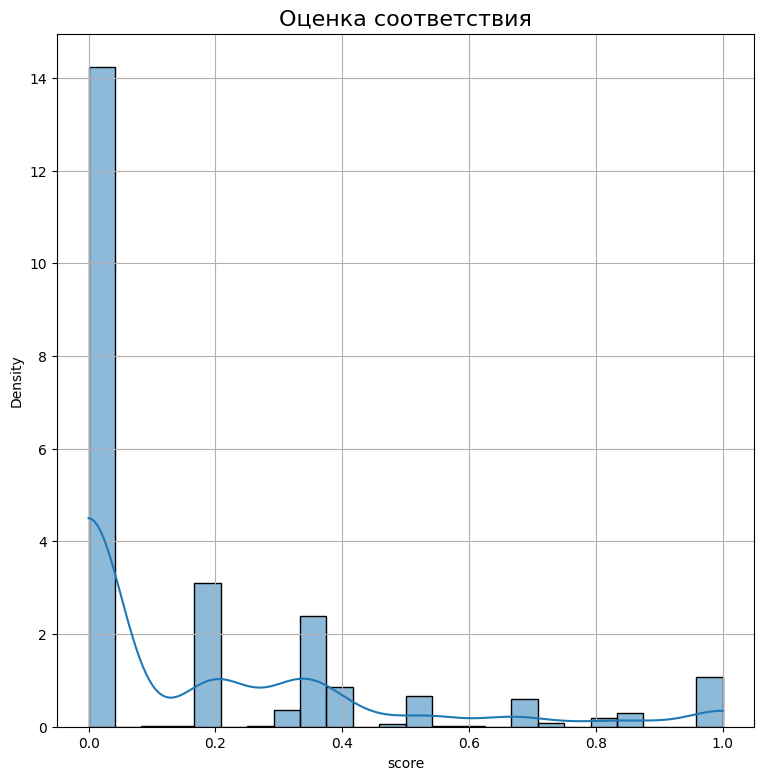

In [40]:
# Строим гистаграмму по возрасту машины.
plt.subplots(figsize=(9, 9))
plt.title('Оценка соответствия', fontsize=16)
sns.histplot(      # гистограммы плотности
            clean_train['score'],
            kde=True,
            stat="density", 
            linewidth=1)       
plt.grid(True)
plt.show()

In [41]:
print('Среднее по оценке', round(clean_train['score'].mean(), 3))

Среднее по оценке 0.177


In [42]:
clean_train = clean_train[['image','lemm_text', 'score']].reset_index(drop=True) # Переформеруем индексы, необходимо для разделения.

#### Вывод по результатам обработки 

- Для соблюдения юредических ограничений пришлось удалить 1/3 всех изображений, если бы не поставили ограничения на оценку пришлось бы удалить почти 70%;
- Средняя оценка 0.18 довольно низкая очень мало картинок, которые полностью соответсвуют описанию, и не понятно, что именно на картинке этому описанию соответствует огда описание неже 0.5 скажем.

### Векторизация изображений

In [43]:
# Разбиваем на train и test.
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=clean_train.drop(columns=['score']), y=clean_train['score'], groups=clean_train['image']))
train_df, test_df = clean_train.loc[train_indices], clean_train.loc[test_indices]
print(train_df.shape)
print(test_df.shape)

(2532, 3)
(1105, 3)


**Коментарий** - разбиение сделал перед векторизацией, это связана с тем что возвращаятся с тензеров в DF, почти невозможно ресурсов, не хватает.


In [44]:
# Для оптимиза работы при векторизации изображений, отсортируем датасеты по изображениям.
train_df = train_df.sort_values(by='image')
test_df = test_df.sort_values(by='image')

In [45]:
# Подготовим списки изображений и количевто их упоменаний.
image_number_train = train_df['image'].value_counts(sort=False).reset_index()
image_number_test = test_df['image'].value_counts(sort=False).reset_index()

In [46]:
# Загружаем предобученную ResNet50.
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
for param in resnet.parameters():
    param.requires_grad_(False) 

In [48]:
# Формируем модель без двух нижних слоев.
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules) 
resnet.eval() 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [49]:
# Готовим трансформатор для подготовки картинок.
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

In [50]:
# Получаем вектор для тренировочных картинок.
all_img = []
for fail in tqdm(image_number_train['index'].values):
  img = Image.open('/content/to_upload/train_images/'+ fail).convert('RGB')
  image_tensor = preprocess(img)
  output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
  image_count = int(image_number_train[image_number_train['index'] == fail]['image'].values)
  for i in range(image_count):
    all_img.append(output_tensor)
  img.close() 

  0%|          | 0/464 [00:00<?, ?it/s]

In [51]:
# Получаем общий тренировочных  данных.
tain_img = torch.stack(all_img, 0)

In [52]:
# Проверяем размер.
tain_img.shape

torch.Size([2532, 100352])

In [53]:
# Получаем вектор для тестовых картинок.
all_img = []
for fail in tqdm(image_number_test['index'].values):
  img = Image.open('/content/to_upload/train_images/'+ fail).convert('RGB')
  image_tensor = preprocess(img)
  output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
  image_count = int(image_number_test[image_number_test['index'] == fail]['image'].values)
  for i in range(image_count):
    all_img.append(output_tensor)
  img.close() 

  0%|          | 0/199 [00:00<?, ?it/s]

In [54]:
# Получаем общий тензор тестовых данных.
test_img = torch.stack(all_img, 0)

In [55]:
# Проверяем размер.
test_img.shape

torch.Size([1105, 100352])

### Векторизация текста

In [56]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
# Устанавливаем стоп слова.
stop_words = stopwords.words('english')
stop_words.remove('not')

In [58]:
# Перводим леммы в вектор.
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
count_tf_idf.fit(train_df['lemm_text'])
tf_idf_train = count_tf_idf.transform(train_df['lemm_text'])
tf_idf_test = count_tf_idf.transform(test_df['lemm_text'])

In [59]:
# Проверяем результат.
print(tf_idf_train.shape)
print(tf_idf_test.shape)

(2532, 1070)
(1105, 1070)


### Объединение векторов

In [60]:
# Перевод матрицы в тензоры.
tf_idf_train = torch.FloatTensor(tf_idf_train.toarray())

In [61]:
# Перевод матрицы в тензоры.
tf_idf_test = torch.FloatTensor(tf_idf_test.toarray())

In [62]:
# Проверяем результат
tf_idf_train.shape

torch.Size([2532, 1070])

In [63]:
# Конкатенируем вектора.
train_tensor= torch.cat((tain_img, tf_idf_train), -1)

In [64]:
# Конкатенируем вектора.
test_tensor = torch.cat((test_img, tf_idf_test), -1)

In [65]:
# Проверяем результат.
train_tensor.shape

torch.Size([2532, 101422])

In [66]:
# Проверяем результат.
test_tensor.shape

torch.Size([1105, 101422])

### Выводы

- После векторизации изображения замер вектора составляет 100352 параметра для ResNet50 для ResNet18 он где-то 25к;
- Вектор же текста значительно меньше всего 1070, и это при условии что при векторизации параметр min_df не установлен, если мы попытаемя отбросить часть слов то получется где-то 400;
- Сильный перекос в сторону вектора изорражений, это может очень повлиять на моделирования, модели просто не замет вектор текста, темболее для нее нет разницы между этими параметрами;
- Перейти в датафрейм с таким тензором просто не получается, оперативная память заканчивается.   

## Обучение модели предсказания соответствия

В качестве, метрики выбрал RMSE, модели с ним работают быстрее. И дело тут не в мерике, а скорей в подходе.

### LinearRegression

In [67]:
%%time
lr = LinearRegression() # Обучим линейную регрессию.
lr.fit(train_tensor, train_df['score'])

CPU times: user 3min 3s, sys: 27.6 s, total: 3min 30s
Wall time: 2min 6s


LinearRegression()

In [68]:
predicted_train = lr.predict(train_tensor)

In [69]:
round(mean_squared_error(train_df['score'], predicted_train) ** 0.5, 3) # Метрика на train.

0.3

### DecisionTree

In [70]:
parameters = {'max_depth': [12, 16], 
             'max_features':[600]} 

In [71]:
dtr = DecisionTreeRegressor(random_state=12345)

In [72]:
dtr_model = GridSearchCV(dtr, parameters, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1) #Задаем параметры модели и поиска.

In [73]:
%%time
dtr_model.fit(train_tensor, train_df['score']) # Обучим дерево решений.

CPU times: user 8.44 s, sys: 20.3 s, total: 28.7 s
Wall time: 1min 5s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [12, 16], 'max_features': [600]},
             scoring='neg_root_mean_squared_error')

In [74]:
dtr_model.best_params_

{'max_depth': 16, 'max_features': 600}

In [75]:
predicted_train = dtr_model.best_estimator_.predict(train_tensor)

In [76]:
round(mean_squared_error(train_df['score'], predicted_train) ** 0.5, 3)  # Метрика на train.

0.108

### RandomForest

In [77]:
parameters = {'n_estimators': [200],
                'max_depth': [12],
             'max_features':[400]}

In [78]:
rfr = RandomForestRegressor(random_state=12345)

In [79]:
rfr_model = GridSearchCV(rfr, parameters, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1) #Задаем параметры модели и поиска.

In [80]:
%%time
rfr_model.fit(train_tensor, train_df['score']) # Обучаем модель.

CPU times: user 2min 16s, sys: 8.93 s, total: 2min 25s
Wall time: 10min 9s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [12], 'max_features': [400],
                         'n_estimators': [200]},
             scoring='neg_root_mean_squared_error')

In [81]:
predicted_train = rfr_model.best_estimator_.predict(train_tensor)

In [82]:
round(mean_squared_error(train_df['score'], predicted_train) ** 0.5, 3) # Метрика на train.

0.171

### Нейронная сеть

In [83]:
# Параметры НС.
n_in_neurons = train_tensor.shape[1]
n_hidden_neurons_1 = 400
n_hidden_neurons_2 = 5
n_out_neurons = 1
learning_rate = 0.01
num_epochs = 10000

In [84]:
# Создаем класс новой НС, определяем два метода.
class Baseline_new(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_out_neurons, p1, p2):
        super(Baseline_new, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Tanh()
        self.dp1 = nn.Dropout(p=p1)
       
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=p2)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()
       
       
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
       
        return x

In [85]:
net_parametrs = {
    'set_1': [100, 0, 0]
    #'set_2': [21, 0, 0],
    #'set_3': [84, 0.5, 0.25],
    #'set_4': [21, 0.5, 0.25],
    #'set_5': [84, 0.8, 0.25],
    #'set_6': [21, 0.8, 0.25],
}

In [86]:
rmse_train_set = ['rmse_train']
rmse_test_set = ['rmse_test']

In [87]:
y_train = torch.FloatTensor(train_df['score'].values)
y_test = torch.FloatTensor(test_df['score'].values)

In [88]:
# Запускаем обучение.
for sets, params in net_parametrs.items():
    
    net = Baseline_new(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, params[1], params[2])
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss = nn.MSELoss()
    batch_size = params[0]
    num_batches = ceil(len(train_tensor)/batch_size)
    
    num_epochs = 10
    for epoch in tqdm(range(num_epochs)):
        order = np.random.permutation(len(train_tensor))# создайте случайную перестановку индексов объектов
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size # посчитайте номер стартового объекта батча
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index+batch_size] # извлеките индексы объектов текущего обатча
            X_batch = train_tensor[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
    
    net.eval()
    
    pred_train = net.forward(train_tensor).detach().numpy()
    pred_test = net.forward(test_tensor).detach().numpy()
    rmse_train = sqrt(mean_squared_error(train_df['score'], pred_train))
    rmse_test = sqrt(mean_squared_error(test_df['score'], pred_test))
    rmse_train_set.append(rmse_train)
    rmse_test_set.append(rmse_test)

  0%|          | 0/10 [00:00<?, ?it/s]

In [89]:
round(rmse_train, 3) # Метрика на train.

0.274

In [90]:
max(pred_train) # проверим качество предсказаний.

array([0.2642192], dtype=float32)

### Выводы

- Для LR не стал сильно углубляться т.к посути это просто подчет по формуле в своем итоге, длаее на тесте посомтрим дейсвительный результат ее работы.
- Для древянных моделей перепробывал много гиперпараметров на случайном дереве потом их просто перевел на лес, сильно они не дают прироста или улучшения. Тут дела в данных и их форме и в отработке ResNet.
- Нейро сеть пробовал все и состав и слои и функции активации и батчи, по итогу нейро сеть делает 2 вещи или ставить всем 0 (при больших внутрених слоях походу градиент просто затухает), или находит усредненое значени в районе 0.2 или плюс минус 0.05 выставляет остальные.
- Лес требует много ресурсов и часто вешает проект.
- Была идея попробовать Логистическую регрессию и сделать на скорах, но тут не бинарный таргет, и сильный дисбаланс. Хотя можно приветси к бинарному таргету посмотреть какой там будет roc auc и поиграть с порогом для улучшения precision.

# Тестирование модели

### Сравнение моделей

Буду проводить  тестирования на всех моделях для наглядности и обосновоности вывода. Т.к. это иследовательская работа думаю это допустимо.

In [91]:
# Посчитаем метрику случайной модели, все значению 0 поитогу картинка выбирается случайно та что сверху присортировке. 
rmse_zeros = mean_squared_error(test_df['score'], np.zeros(len(test_df['score'])))**0.5
print(f'rmse случайной модели {rmse_zeros: .3f}')
random_m = ['random_model', round(rmse_zeros, 3)]

rmse случайной модели  0.315


In [92]:
predicted_test = lr.predict(test_tensor)

In [93]:
predicted_test = lr.predict(test_tensor)
rmse_lr = mean_squared_error(test_df['score'], predicted_test )**0.5
lr_m = ['LR', round(rmse_lr, 3)]

In [94]:
# Попробуем исправить работу LR. 
a = pd.Series(predicted_test).reset_index()

In [95]:
a[(a[0] < 0)] = 0 
a[(a[0] > 1)] = 1 

In [96]:
# Метрика исправленой модели.
rmse_lr_m = mean_squared_error(test_df['score'], a[0])**0.5
lr_m_mod = ['LR_limit', round(rmse_lr_m, 3)]

In [97]:
# Метрики для RForest.
predicted_test = dtr_model.best_estimator_.predict(test_tensor)
rmse_dtr = mean_squared_error(test_df['score'], predicted_test) ** 0.5
dtr_m = ['DTR', round(rmse_dtr, 3)]

In [98]:
# Метрики для DT.
predicted_test = rfr_model.best_estimator_.predict(test_tensor)
rmse_rfr = mean_squared_error(test_df['score'], predicted_test) ** 0.5
rfr_m = ['RFR', round(rmse_rfr, 3)]

In [99]:
# Метрика для NN.
nn_m = ['NN', round(rmse_test, 3)]

In [100]:
# Вывод по моделированию 
columns =[
    'model',
    'rmse'
]
data = []


data.append(random_m)
data.append(lr_m)
data.append(lr_m_mod)
data.append(dtr_m)
data.append(rfr_m)
data.append(nn_m)

pd.DataFrame(data=data, columns=columns)

model      rmse
0  random_model     0.315
1            LR  5118.583
2      LR_limit     0.664
3           DTR     0.336
4           RFR     0.252
5            NN     0.262

#### Вывод

- RFR самая лучшая модель, но она не сильно ушла от случайной
- LR - просто не сопособно что-то предсказать все е предсказания или сильно больше 1 или сильно меньше 0, даже если мимы попытаемя ее как-то урановесить, ни чего не получается.
- про NN было написано выше, она чуть лучше случайноq, но очень мальнькие размличия между предсказаниями.
- И все это закономер. Есть тензоры которые на 1% отличаются друг от друга (одно изображение разные описания) и для них разнае значения таргета, это различие теряется в усреднении, модели немогнут уловить эти нюансы.   
- Проверку на реальных данных проведу на Rfndom Forest.

### Тестирование модели на изображениях 

In [101]:
# Загружаем датасет с тестовыми картинками.
test_images = pd.read_csv('/content/to_upload/test_images.csv')

In [102]:
test_images.sample(10) # Проверяем загрузку данных.

image
38  3455405300_aa3069ecaa.jpg
24  3421547427_53411b6278.jpg
34  2597308074_acacc12e1b.jpg
83  2505056124_1276e8dbcb.jpg
74  3170110692_d1e0e66cee.jpg
15  1468389504_c724bdcad0.jpg
60  3173157541_70b16b4318.jpg
27  3287969199_08e775d896.jpg
8   2977379863_2e8d7a104e.jpg
66  1319634306_816f21677f.jpg

In [103]:
# Получаем вектор для тестовых картинок.
all_img = []
for fail in tqdm(test_images['image'].values):
  img = Image.open('/content/to_upload/test_images/'+ fail).convert('RGB')
  image_tensor = preprocess(img)
  output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
  all_img.append(output_tensor)
  img.close() 

  0%|          | 0/100 [00:00<?, ?it/s]

In [104]:
test_img_tensor = torch.stack(all_img, 0)

In [105]:
# Проверяем тензор.
test_img_tensor.shape

torch.Size([100, 100352])

In [106]:
# Загружаем запрос с тестовыми запросами.
test_queries = pd.read_csv('/content/to_upload/test_queries.csv', sep='|', index_col=0)

In [107]:
test_queries.sample(10) # Проверяем загрузку данных.

query_id  \
262  3173157541_70b16b4318.jpg#2   
117  2461990494_c5ece064cc.jpg#2   
221  3089107423_81a24eaf18.jpg#1   
186  2977379863_2e8d7a104e.jpg#1   
485   973827791_467d83986e.jpg#0   
74   2141713971_e25eb12712.jpg#4   
487   973827791_467d83986e.jpg#2   
269  3184031654_34b5c4ffe1.jpg#4   
389  3520936130_9e90872560.jpg#4   
254  3163198309_bbfe504f0a.jpg#4   

                                            query_text  \
262  A man with a white hat and plaid shirt behind ...   
117  An adult male wearing a backpack walks and loo...   
221  A man is operating a television camera high up...   
186  A girl in a black cape with a group of other c...   
485  A little kid splashes around in the kiddie poo...   
74     Two people on a sled riding down a snowy hill .   
487  A woman is throwing a bucket of water over a b...   
269                          Two women in head wraps .   
389  Two people sit on a wooden bench and face each...   
254  There are several people watching a person in ...   

                         image  
262  3173157541_70b16b4318.jpg  
117  2461990494_c5ece064cc.jpg  
221  3089107423_81a24eaf18.jpg  
186  2977379863_2e8d7a104e.jpg  
485   973827791_467d83986e.jpg  
74   2141713971_e25eb12712.jpg  
487   973827791_467d83986e.jpg  
269  3184031654_34b5c4ffe1.jpg  
389  3520936130_9e90872560.jpg  
254  3163198309_bbfe504f0a.jpg

In [113]:
# Функция вывода картинки по запросу, на вход:
#- запрос;
#- список ограничений, для вывода предупреждения:
#- тензор картинок для поиска;
#- модель;
#- датафрем с адресами картинок;
# Функция выводить топ 4 самых подходящих картинок.

 
def model_test(query, legal_restrictions,test_img_tensor, ml_mod, test_images):
  lemm_query = text_preprocessing_spacy(query)
  if max([ext in lemm_query for ext in legal_restrictions]):
    print ('This image is unavailable in your country in compliance with local laws.')
  else:
    tf_idf = count_tf_idf.transform([lemm_query]).toarray()
    tf_idf = np.repeat(tf_idf, [100], axis=0)
    tf_idf = torch.FloatTensor(tf_idf)
    tensor = torch.cat((test_img_tensor, tf_idf), -1)
    pred = ml_mod.predict(tensor)
    #pred = net.forward(tensor).detach().numpy().reshape(1, 100)[0]
    pred = pd.Series(pred, index=test_images.index)
    images = pd.concat([test_images, pred], axis=1)
    images = images.sort_values(by=0, ascending=False)['image'].head(6)
    fig = plt.figure(figsize=(10,10))
    images = images.values
    for i in range(len(images)):
      img = Image.open('/content/to_upload/test_images/'+ images[i]).convert('RGB')
      fig.add_subplot(4, 4, i+1)

      plt.imshow(img)
    # для компактности удаляем оси и прижимаем изображения друг к другу
      plt.xticks([])
      plt.yticks([])
      plt.tight_layout()
      img.close()
  plt.show()

In [114]:
# Случайный списко запросов.
samples = test_queries['query_text'].sample(10) #  Выбираем 10 случайных запросов.

A dog wrapped with straps is walking away from a red tray holding a bag .


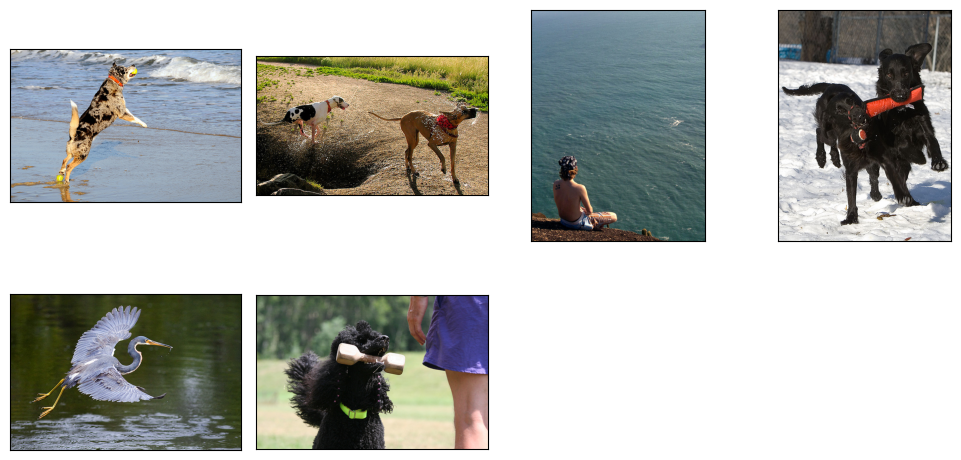

Two men are standing under a large work of art by a brick building .


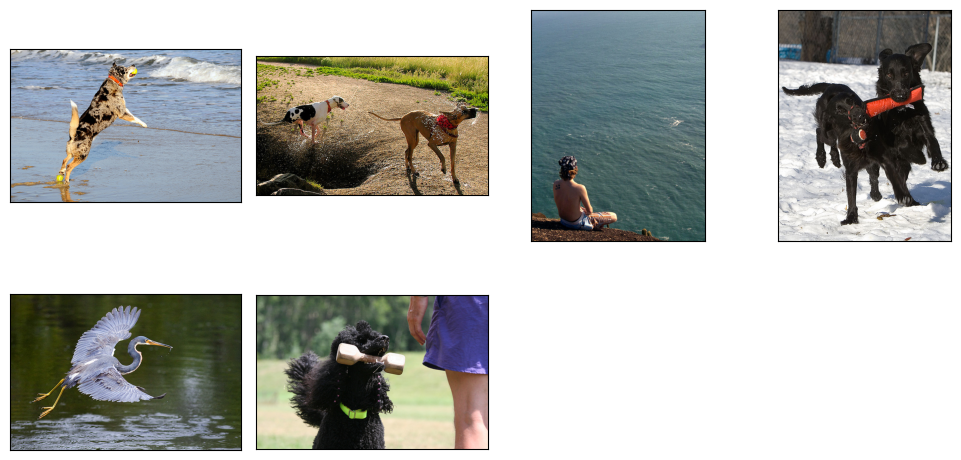

Two dogs playing outside near the water .


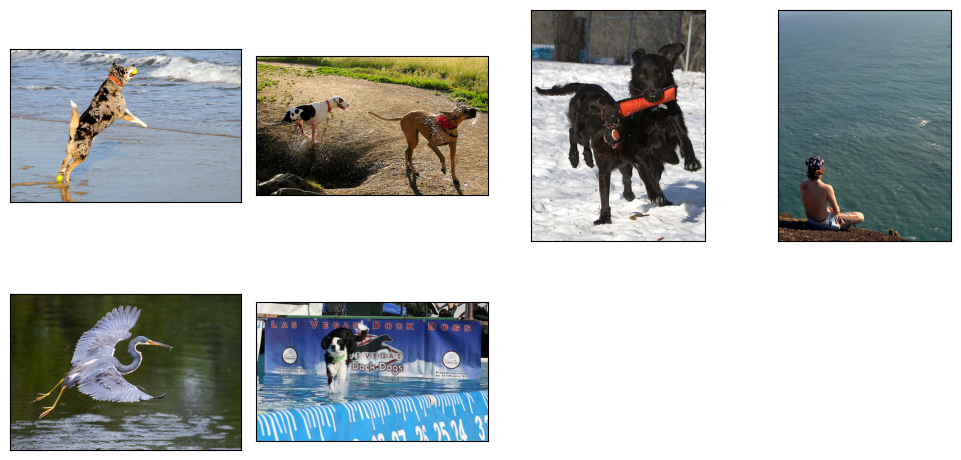

A dog jumping for a tennis ball near an ocean


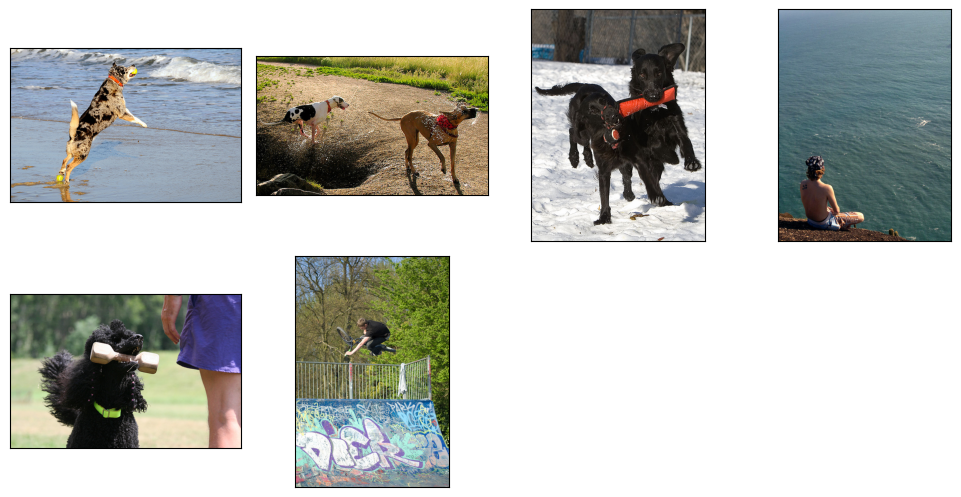

The man in the backpack looks to his left .


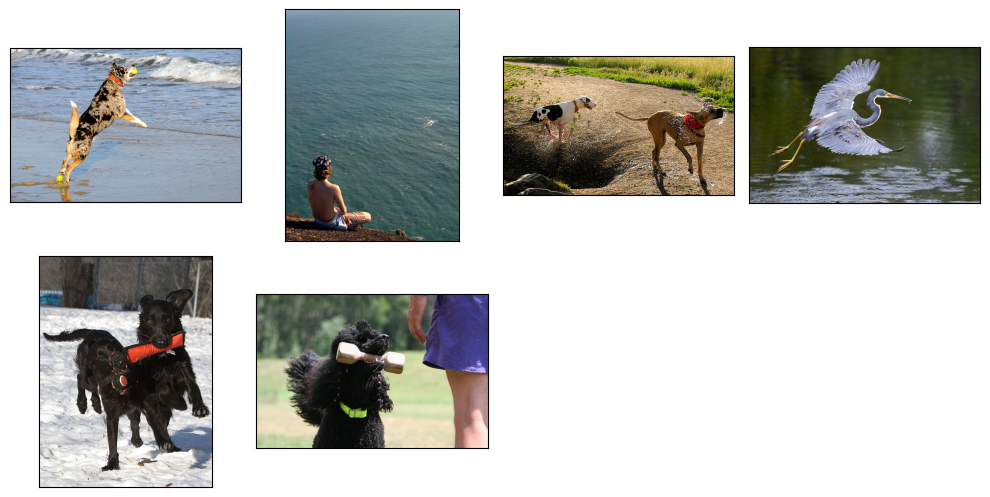

A boy holds a red bucket up to a pony .
This image is unavailable in your country in compliance with local laws.
A blue bird flying over water .


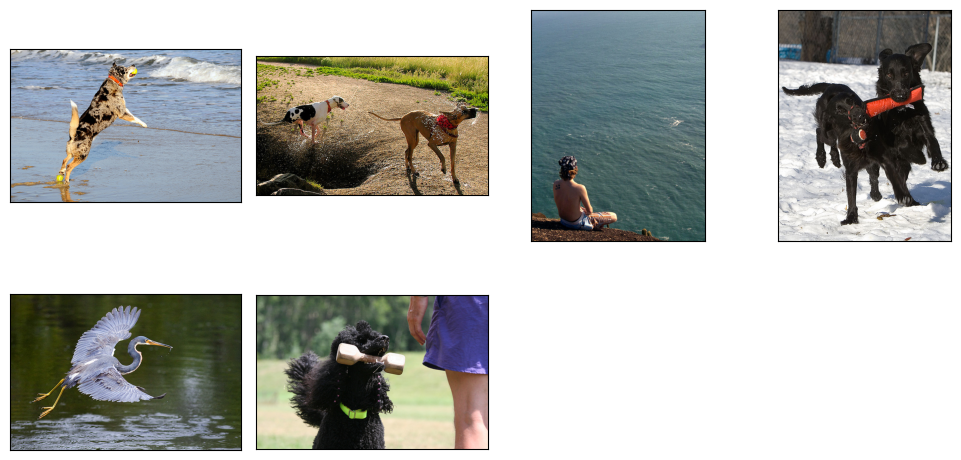

A man on an orange bike .


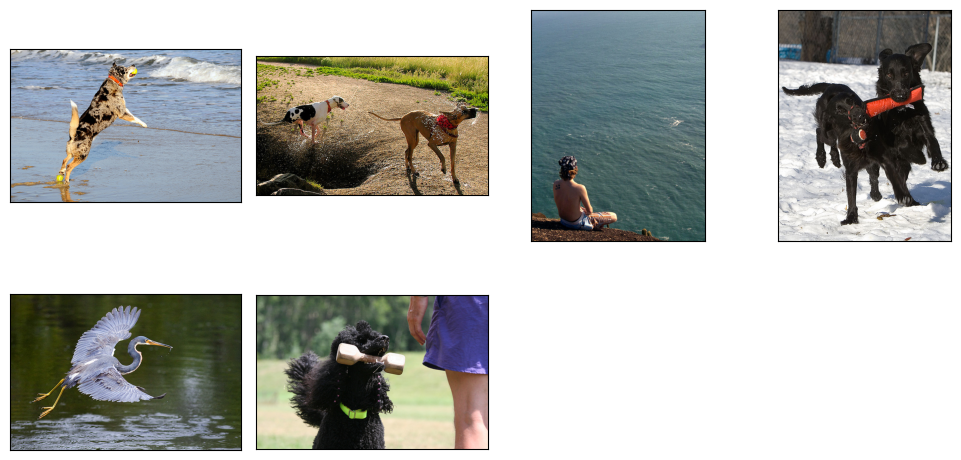

Child in blue and grey shirt jumping off hill in the woods
This image is unavailable in your country in compliance with local laws.
A snowboarder takes a ramp made of snow while others watch .


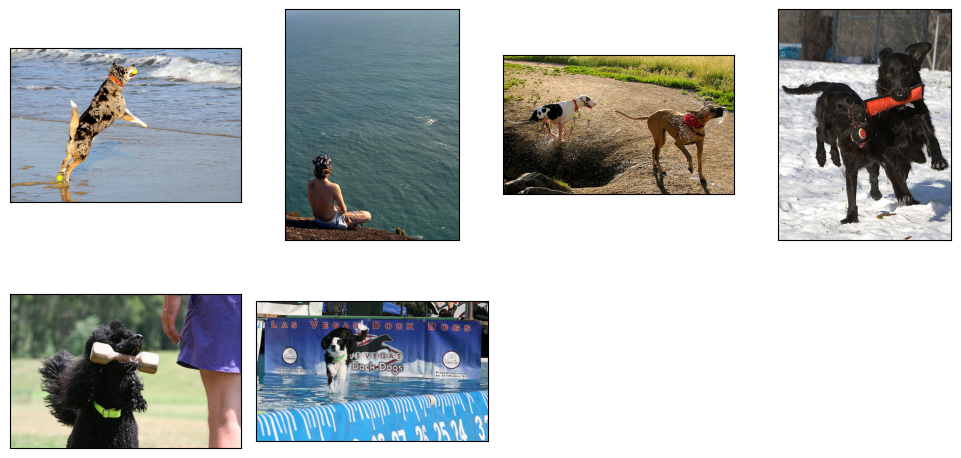

In [115]:
# Результат работы.
for s in samples: 
  print(s)
  model_test(s, legal_restrictions, test_img_tensor, rfr_model.best_estimator_, test_images)

## Общий вывод

1. Модель в общем случаи не учится искать, а создает себе пул наиболее подходящих какртинок, на все ответы. Да иногда этот пул меняеться. Но в общем случаи этот так.  Модель иногда «везет».
2. Это модель научилось хорошо искать собачек, тоже неплохо, другие хорошо искали людей.
3. Есть проблема с поиском детей т.к. картинки с детьми в тестовых данных есть, а модель не научилась их отлечать и в итоге может выдасть картинку с ребенкам на запрос не содержащий этого требования. Это плохо необходимо обучать модель со всмеми зазпросами, а потом на этапе предсказаний отсекать отдельным фильром сами картинки.
4. Сам подход не жизне способен (использовать конкатенированный вектор из требования задачи) из-за дисбаланса. Вектор текстового запроста просто теряется в массиве вектора изображения. 
5. Эту задачу предположительно можно решить так, при помощи сверточных сети разметить существующие картинки и выделить в них объекты и их количества и сделать текствое описание(теги) картинки. А потом при помощи простого измерения векторного расстояния сравнивать два текстовых вектора, вектор запроса и вектор тегов. И выдавать наиболее близкий результат. Но это другая задача.